In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import cartopy.crs as ccrs
from cartopy.io import srtm
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import pandas as pd

## IMPORT CONTOUR

In [13]:
mountain = pd.read_csv("mountain.csv", header=None)
mountain.columns=['Longitude','Latitude','Nama']
mountain['Nama'] = mountain['Nama'].astype(str)
plt.style.use('seaborn-whitegrid')
df_ = pd.read_csv("result_ALL_1218.csv")
df_fslice = df_[['Magnitude', 'Northing', 'Easting','Depth']].copy()
df_fslice = df_fslice[['Easting','Northing','Depth','Magnitude']]
df_fslice['Depth'] = df_fslice['Depth']*-1


In [14]:
contour = pd.read_csv("Fixdot.csv")
conPEN = contour[(contour['xcoord'] >= 115.25) & (contour['xcoord'] <= 115.7) & (contour['ycoord'] >= -8.5 ) & (contour['ycoord'] <= -8.15 )]
koor = conPEN.drop(columns = ['GM_LAYER','GM_TYPE','KETERANGAN', 'LAYER', 'vertex_index', 'vertex_part', 'vertex_part_index','distance','angle'])
koor['xcoord'] = round(koor['xcoord'],4)
koor['ycoord'] = round(koor['ycoord'],4)



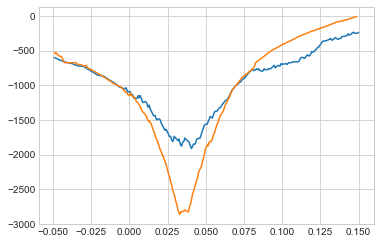

In [15]:
kor = np.array([[[115.525,-8.375],[115.425,-8.275]],[[115.507,-8.375],[115.507,-8.25]]])
data = []
for i in kor:
    (lon1 , lon2) = i[0][0], i[1][0]
    (lat1, lat2) = i[0][1], i[1][1]
    sel_lon = lon1-lon2 
    sel_lat = lat1-lat2
    slc = koor[(koor['xcoord'] >= lon1 ) & (koor['xcoord'] <= lon2 ) & (koor['ycoord'] >= lat1 ) & (koor['ycoord'] <= lat2 )]
    if sel_lat < 0:
        sel_lat = sel_lat*-1
    if sel_lon < 0:
        sel_lon = sel_lon*-1

    if (sel_lon < sel_lat) & (sel_lon != 0):
        nam = sel_lon
    elif (sel_lon > sel_lat) & (sel_lat != 0):
        nam = sel_lat
    elif sel_lon == 0:
        nam = sel_lat
    elif sel_lat == 0:
        nam = sel_lon

    lonn = np.linspace(lon2+0.05,lon1-0.05, num = int((nam*10000)))
    latt = np.linspace(lat2+0.05,lat1-0.05,num = int((nam*10000)))

    Coor = []
    for i in range(len(lonn)):
        Coor.append([round(lonn[i],4),round(latt[i],4)])
    Coor = np.array(Coor)

    x = []
    y = []
    z = []
    for i in range(len(lonn)):
        a = koor['ELEVATION'].loc[(koor['xcoord'] == Coor[i][0]) & (koor['ycoord'] == Coor[i][1])]
        if a.count() != 0:
            x.append(Coor[i][0])
            y.append(Coor[i][1])
            z.append(a.iloc[0])
    xel = np.array(x)
    yel = np.array(y)
    zel = np.array(z)
    if lat1>lat2:
        m=lat2*-1
    else:
        m=lat1*-1
    yel = (yel+m)
    zel= zel*-1
    plt.plot(yel,zel)
    data.append([xel,yel,zel])


In [20]:
class Slice:
    '''
    class untuk buat objek slicing peta.
    '''
    
    def __init__(self,kor, df, mount, data, s=None):
        self.kor = kor
        self.t1 = []
        self.t2 = []
        self.xel = []
        self.yel = []
        self.zel = []
        for i in range (len(kor)): 
            self.t1.append(kor[i][0])
            self.t2.append(kor[i][1])
#         print(self.t1) : [array([115.525,  -8.37 ]), array([115.45,  -8.35])]
        for i in range (len(data)):
            self.xel.append(data[i][0])
            self.yel.append(data[i][1])
            self.zel.append(data[i][2])
        self.x, self.y, self.z, self.mag = df['Easting'] , df['Northing'],  df['Depth'], df['Magnitude']
        self.xmoun , self.ymoun, self.nmoun = mount['Longitude'], mount['Latitude'], mount['Nama']
        self.s = s
        if s:
            self._create_rectangle()
            self._inside_bound()
            self._project_to_slice()
            
        else:
            self._project_to_slice()
            
    
    def _create_rectangle(self):
        # create new basis vector
        b1 = []
        self.bound = []
        for i in range(len(self.t1)): #len nya 2
            b1 = self.t2[i] - self.t1[i]
            rot = np.array([[0, 1], 
                            [-1, 0]])
            b2 = rot.dot(b1)
            new_basis = np.array([[b2[0], b1[0]],
                                  [b2[1], b1[1]]])

            # vector length of the desired window in new basis vector 
            n = self.s / np.linalg.norm(b2)
            v = new_basis.dot(np.array([[n], [0]]))
            ds = v[:, 0]

            # rectangle vertices
            # titik akhir harus = titik awal
            # agar membentuk poligon tertutup
            rectangle = np.array([[self.t1[i] + ds],
                                  [self.t2[i] + ds],
                                  [self.t2[i] - ds],
                                  [self.t1[i] - ds],
                                  [self.t1[i] + ds]])

            self.bound.append(rectangle[:, 0])
        return self
    
    def _inside_bound(self):
        a = self.x
        b = self.y
        c = self.z
        d = self.mag
        e = self.xmoun
        f = self.ymoun
        g = self.nmoun
        self.x =[]
        self.y =[]
        self.z =[]
        self.mag = []
        self.xmoun = []
        self.ymoun = []
        self.nmoun = []
        for i in range(len(self.bound)):
            p = Path(self.bound[i])
            mask = p.contains_points(np.c_[a, b])
            mask1 = p.contains_points(np.c_[e,f])
            self.x.append(a[mask])
            self.y.append(b[mask])
            self.z.append(c[mask])
            self.mag.append(d[mask])
            self.xmoun.append(e[mask1])
            self.ymoun.append(f[mask1])
            self.nmoun.append(g[mask1])
        return self
    
    def _project_to_slice(self):
        '''
        p1 = coordinate of 1 point
        p2 = coordinate of another point
        p1 and p2 forms a line in which we want to project
        points with x and y coordinates into

        returns distance of point (x,y) relative to point p1
        '''
        self.newx = []
        self.newxm = []
        self.line_length = []
        for i in range(len(self.t1)):
            v = (self.t2[i] - self.t1[i]).reshape(1, 2)
            xy = np.c_[self.x[i], self.y[i]].T
            xym = np.c_[self.xmoun[i], self.ymoun[i]].T
            xy = xy - self.t1[i][:, None]        
            xym = xym - self.t1[i][:, None]
            newx = (v @ xy) / np.linalg.norm(v)
            newxm = (v @ xym) / np.linalg.norm(v)
            self.newx.append(newx)
            self.newxm.append(newxm)
            self.line_length.append(np.linalg.norm(v))
        return self
    
    def plot_map(self, ax=None, **params):
        
        if ax is None:
            ax = plt.axes(projection=ccrs.PlateCarree())
        for i in range (len(self.bound)):
            if self.s is not None:
                p = Path(self.bound[i])
                patch = patches.PathPatch(p, lw=2, facecolor = 'None', alpha=1, linestyle="--")   
                ax.add_patch(patch)
        stamen_terrain = cimgt.Stamen('terrain-background')
        ax.add_image(stamen_terrain,10)
        ax.set_extent([115.36, 115.604,  -8.45, -8.2])
#         eq = ax.scatter(self.x, self.y, c='g',s=self.mag**4, **params)
#         ax.scatter(self.x, self.y, c='g', **params)
        ax.set_xlabel("Longitude [deg]")
        ax.set_ylabel("Latitude [deg]")
        gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, zorder=11)
        gl.xlabels_top = False
        gl.ylabels_right = False
        
        abjad = "ABCD"
        
        for i in range(len(self.t1)):
            ax.plot((self.t1[i][0], self.t2[i][0]), 
                    (self.t1[i][1], self.t2[i][1]), 'ro-')

            ax.annotate(abjad[i], 
                        xy = (self.t1[i][0], self.t1[i][1]),
                        size=15)
            ax.annotate(abjad[i]+"''", 
                        xy = (self.t2[i][0], self.t2[i][1]),
                        size=15)
        eq = plt.scatter(df_fslice['Easting'], df_fslice['Northing'], s=df_fslice['Magnitude']**4, **params)
        plt.legend(title="Magnitude", loc="lower left", \
           *eq.legend_elements("sizes", num=5, func=lambda x: x**(1/4) )).set_zorder(102)
        plt.scatter(mountain['Longitude'], mountain['Latitude'],s = 100, marker = '^', c = 'r' )
        ax.annotate(mountain['Nama'][0], xy = (mountain['Longitude'][0], mountain['Latitude'][0]),size=15)
        ax.annotate(mountain['Nama'][1], xy = (mountain['Longitude'][1], mountain['Latitude'][1]),size=15)
        
        plt.show()
    def plot_vsection(self, ax1=None, **params):
        fig, ax1 = plt.subplots(len(self.t1))
        abjad = "ABCD"
        for i in range(len(self.t1)):
            bq = ax1[i].scatter(self.newx[i], self.z[i], s = self.mag[i]**4, **params)        


            ax1[i].annotate(abjad[i], 
                        xy=(0,self.yel[i].max()),
#                         xytext=(self.line_length[i], 1), 
                        size=15, fontweight = 'bold'
                       )
            
            ax1[i].set_xlim(0, self.line_length[i])
            ax1[i].scatter(self.newxm[i][0][0],self.zel[i].min(), s = 40, c = 'r', marker = '^')
            ax1[i].annotate("Gunung "+self.nmoun[i][0], xy = (self.newxm[i][0][0],self.zel[i].min()), size=10, fontweight = 'bold')
            ax1[i].plot(self.yel[i],self.zel[i])
            ax1[i].legend(title="Magnitude", loc="center left", bbox_to_anchor=(1, 0.5), *bq.legend_elements("sizes", num=5, func=lambda x: x**(1/4) )).set_zorder(102)
            ax1[i].annotate(abjad[i]+"'", xy = (self.newx[i].max(),self.yel[i].max()), size=15, fontweight = 'bold')
            ax1[i].invert_yaxis()


C:\Users\asus\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\asus\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


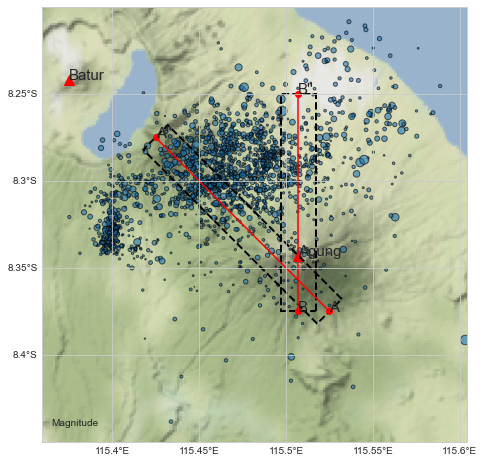

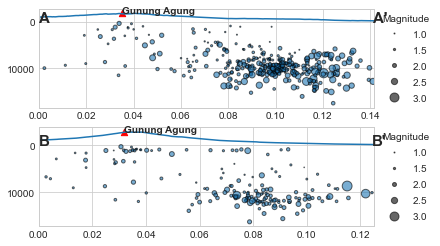

In [22]:
params = {'edgecolor':'black', 'alpha':0.6}
slice1 = Slice(kor, df_fslice, mountain, data, s=0.01)
plt.figure(figsize=(20, 8))
plt.subplot(212)
slice1.plot_map(**params)
slice1.plot_vsection(**params)

plt.savefig("image.png", dpi = 1200)